In [1]:
import os
import glob
import shutil

import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns

import re
import scipy.stats as spstats
import json
from pipeline.python.classifications import experiment_classes as util

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
   

In [2]:
class struct():
    pass

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

def label_figure(fig, data_identifier):                                                                                                                                     
    fig.text(0, 1,data_identifier, ha='left', va='top', fontsize=8)    

    

In [3]:
%matplotlib notebook

In [4]:
def load_traces(animalid, session, fovnum, curr_exp, traceid='traces001',
               responsive_test='ROC', responsive_thr=0.05, response_type='dff'):
    
    # Load experiment neural data
    fov = 'FOV%i_zoom2p0x' % fovnum
    if curr_exp=='blobs':
        exp = util.Objects(animalid, session, fov, traceid=traceid)
    else:
        exp = util.Gratings(animalid, session, fov, traceid=traceid)
    exp.load(trace_type='dff', update_self=True, make_equal=False)
    labels = exp.data.labels.copy()

    # Get stimulus config info
    sdf = exp.data.sdf
    if curr_exp == 'blobs':
        sdf = reformat_morph_values(sdf)
    n_conditions = len(sdf['size'].unique())

    # Get responsive cells
    responsive_cells, ncells_total = exp.get_responsive_cells(response_type=response_type,\
                                                              responsive_test=responsive_test,
                                                              responsive_thr=responsive_thr)
    
    traces = exp.data.traces[responsive_cells]

    return traces, labels, sdf

def reformat_morph_values(sdf):
    control_ixs = sdf[sdf['morphlevel']==-1].index.tolist()
    sizevals = np.array([round(s, 1) for s in sdf['size'].unique() if s not in ['None', None] and not np.isnan(s)] )
    sdf.loc[sdf.morphlevel==-1, 'size'] = pd.Series(sizevals, index=control_ixs)
    sdf['size'] = [round(s, 1) for s in sdf['size'].values]

    return sdf


In [5]:
def traces_to_trials(traces, labels, epoch='stimulus'):
    '''
    Returns dataframe w/ columns = roi ids, rows = mean response to stim ON per trial
    Last column is config on given trial.
    '''
    s_on = int(labels['stim_on_frame'].mean())
    n_on = int(labels['nframes_on'].mean())

    roi_list = traces.columns.tolist()
    trial_list = np.array([int(trial[5:]) for trial, g in labels.groupby(['trial'])])
    if epoch=='stimulus':
        mean_responses = pd.DataFrame(np.vstack([np.nanmean(traces.iloc[g.index[s_on:s_on+n_on]], axis=0)\
                                            for trial, g in labels.groupby(['trial'])]),
                                             columns=roi_list, index=trial_list)
    elif epoch == 'baseline':
        mean_responses = pd.DataFrame(np.vstack([np.nanmean(traces.iloc[g.index[0:s_on]], axis=0)\
                                            for trial, g in labels.groupby(['trial'])]),
                                             columns=roi_list, index=trial_list)

    condition_on_trial = np.array([g['config'].unique()[0] for trial, g in labels.groupby(['trial'])])
    mean_responses['config'] = condition_on_trial

    return mean_responses

# Get aggregate datasets

In [6]:
from pipeline.python.classifications import get_dataset_stats as gd
import cPickle as pkl

options = ['-t', 'traces001']
optsE = gd.extract_options(options)

rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type
traceid = optsE.traceid
response_type = 'dff'
print aggregate_dir

sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(sdata_fpath):
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
else:
    sdata = gd.aggregate_session_info(traceid=optsE.traceid, trace_type=optsE.trace_type, 
                                       state=optsE.state, fov_type=optsE.fov_type, 
                                       visual_areas=optsE.visual_areas,
                                       blacklist=optsE.blacklist, 
                                       rootdir=optsE.rootdir)
    with open(sdata_fpath, 'wb') as f:
        pkl.dump(sdata, f, protocol=pkl.HIGHEST_PROTOCOL)

/n/coxfs01/julianarhee/aggregate-visual-areas


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/get_dataset_stats.py:17: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/juliana

In [9]:
# Select response filters
responsive_test='ROC'
responsive_thr = 0.05
response_type = 'dff'
always_exclude = ['20190426_JC078'] 
# if gratings, also exclude: 20190517_JC083


In [10]:
#dsets = sdata[sdata['experiment']=='blobs'].copy()

incl_ixs = []
for dk, g in sdata.groupby(['animalid', 'session', 'fovnum']):
    if 'blobs' in g['experiment'].values and 'gratings' in g['experiment'].values:
        incl_ixs.extend(g.index.tolist())
        
dsets = sdata.loc[incl_ixs].copy()     
excluded_ixs = [i for i in dsets.index.tolist() for sk in always_exclude
                if (dsets.loc[i]['session']==sk.split('_')[0] and dsets.loc[i]['animalid']==sk.split('_')[1])]
included_ixs = [i for i in dsets.index.tolist() if i not in excluded_ixs]

dsets = dsets.loc[included_ixs]


In [11]:
dsets.groupby(['visual_area']).count()


,animalid,experiment,fov,session,fovnum
visual_area,,,,,
Li,49,49,49,49,49
Lm,24,24,24,24,24
V1,32,32,32,32,32


# Load other data

In [43]:
#### Load mean trial info for responsive cells
data_dir = os.path.join(aggregate_dir, 'data-stats')
os.listdir(data_dir)
epoch = 'baseline'
epoch_str = '' if epoch=='stimulus' else '_baseline'

#### BLOB DATA
load_blobs = False
blobsdata_outfile = os.path.join(data_dir, 'blobs_%s-%s_%s-thr-%.2f%s.pkl' % (traceid, response_type, responsive_test, responsive_thr, epoch_str))
print(blobsdata_outfile)
if os.path.exists(blobsdata_outfile):
    print("...loading data")
    with open(blobsdata_outfile, 'rb') as f:
        BLOBSDATA = pkl.load(f)
else:
    load_blobs = True
    
#### GRATINGS DATA
load_gratings = False
gratingsdata_outfile = os.path.join(data_dir, 'gratings_%s-%s_%s-thr-%.2f%s.pkl' % (traceid, response_type, responsive_test, responsive_thr, epoch_str))
print(gratingsdata_outfile)
if os.path.exists(gratingsdata_outfile):
    print("...loading data")
    with open(gratingsdata_outfile, 'rb') as f:
        GRATINGSDATA = pkl.load(f)
else:
    load_gratings = True

#### Load RF overlap info
luminance_dir = os.path.join(aggregate_dir, 'luminance-analysis')
overlaps_datafile = os.path.join(luminance_dir, 'overlaps-all-RFs.pkl')
assert os.path.exists(overlaps_datafile), "OVERLAPS NOT FOUND."
with open(overlaps_datafile, 'rb') as f:
    overlaprois = pkl.load(f)
    
print("Load blobs:", load_blobs)
print("Load gratings:", load_gratings)

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/blobs_traces001-dff_ROC-thr-0.05_baseline.pkl
...loading data
/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/gratings_traces001-dff_ROC-thr-0.05_baseline.pkl
...loading data
('Load blobs:', False)
('Load gratings:', False)


In [40]:
if load_gratings or load_blobs:
    if load_blobs:
        curr_exp = 'blobs' 
        data_outfile = blobsdata_outfile 
        print("Getting data: %s" % curr_exp)
        print("Saving data to %s" % data_outfile)

        tmpdsets = sdata[sdata['experiment']==curr_exp]
        fovnums = [int(fv.split('_')[0][3:]) for fv in dsets['fov']]
        dsets['fovnum'] = fovnums

        DATA = {}
        for (animalid, session, fovnum), g in tmpdsets.groupby(['animalid', 'session', 'fovnum']):
            datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
            if '%s_%s' % (session, animalid) in always_exclude:
                continue

            # Load traces
            traces, labels, sdf = load_traces(animalid, session, fovnum, curr_exp, 
                                              traceid=traceid, response_type=response_type,
                                              responsive_test=responsive_test, responsive_thr=responsive_thr)
            # Calculate mean trial metric
            mean_responses = traces_to_trials(traces, labels, epoch=epoch)

            DATA['%s' % datakey] = {'data': mean_responses,
                                    'sdf': sdf}

        # Save
        with open(data_outfile, 'wb') as f:
            pkl.dump(DATA, f, protocol=pkl.HIGHEST_PROTOCOL)
        print("Done!")
        del DATA

Getting data: blobs
Saving data to /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/blobs_traces001-dff_ROC-thr-0.05_baseline.pkl
... [JC076|20190420|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... loading data array
/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_5ffca7_traces001_09c921_traces001_512e96_traces001_394d78_traces001_64e684_traces001_6bacb1/data_arrays/np_subtracted.npz
NP_subtracted offset was: 58.87
adding NP offset... (NP baseline offset: 289.30)
((249000, 300), (300,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_5ffca7_traces001_09c921_traces001_512e96_traces001_394d78_traces001_64e684_traces001_6bacb1/summary_stats/ROC/roc_results.pkl']
... [JC076|20190422|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... loading d

... [JC083|20190508|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... loading data array
/n/coxfs01/2p-data/JC083/20190508/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_0f1e0a_traces001_1410d6_traces001_1023f7_traces001_9c6c51_traces001_3ea54b_traces001_249fdc/data_arrays/np_subtracted.npz
NP_subtracted offset was: 102.25
adding NP offset... (NP baseline offset: 590.61)
((262235, 256), (256,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC083/20190508/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_0f1e0a_traces001_1410d6_traces001_1023f7_traces001_9c6c51_traces001_3ea54b_traces001_249fdc/summary_stats/ROC/roc_results.pkl']
... [JC083|20190510|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... loading data array
/n/coxfs01/2p-data/JC083/20190510/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_54393b_traces001_0152b8_traces001_d41efc

... [JC091|20190607|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... loading data array
/n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_2afecb_traces001_8b62a3_traces001_fa925f_traces001_bcbaba_traces001_821fff_traces001_361c93/data_arrays/np_subtracted.npz
NP_subtracted offset was: 51.31
adding NP offset... (NP baseline offset: 427.79)
((202500, 526), (526,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_2afecb_traces001_8b62a3_traces001_fa925f_traces001_bcbaba_traces001_821fff_traces001_361c93/summary_stats/ROC/roc_results.pkl']
... [JC091|20190614|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... loading data array
/n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_1109ae_traces001_920e9d_traces001_8dceeb_

... [JC113|20191018|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... loading data array
/n/coxfs01/2p-data/JC113/20191018/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_45d7bf_traces001_9d98af_traces001_e6dd0f_traces001_af8efe_traces001_53b0c3_traces001_48b222_traces001_5a33cb_traces001_636e28_traces001_9675ee_traces001_c992b1_traces001_deae7e/data_arrays/np_subtracted.npz
NP_subtracted offset was: 78.22
adding NP offset... (NP baseline offset: 1102.53)
((317250, 210), (210,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC113/20191018/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_45d7bf_traces001_9d98af_traces001_e6dd0f_traces001_af8efe_traces001_53b0c3_traces001_48b222_traces001_5a33cb_traces001_636e28_traces001_9675ee_traces001_c992b1_traces001_deae7e/summary_stats/ROC/roc_results.pkl']
... [JC117|20191105|FOV1_zoom2p0x] creating blobs object
... getting data 

In [41]:

if load_gratings:
    curr_exp = 'gratings' 
    data_outfile = gratingsdata_outfile 
    print("Getting data: %s" % curr_exp)
    print("Saving data to %s" % data_outfile)

    tmpdsets = sdata[sdata['experiment']==curr_exp]
    fovnums = [int(fv.split('_')[0][3:]) for fv in dsets['fov']]
    dsets['fovnum'] = fovnums

    DATA = {}
    for (animalid, session, fovnum), g in tmpdsets.groupby(['animalid', 'session', 'fovnum']):
        datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
        if '%s_%s' % (session, animalid) in always_exclude:
            continue

        # Load traces
        traces, labels, sdf = load_traces(animalid, session, fovnum, curr_exp, 
                                          traceid=traceid, response_type=response_type,
                                          responsive_test=responsive_test, responsive_thr=responsive_thr)
        # Calculate mean trial metric
        mean_responses = traces_to_trials(traces, labels, epoch=epoch)

        DATA['%s' % datakey] = {'data': mean_responses,
                                'sdf': sdf}

    # Save
    with open(data_outfile, 'wb') as f:
        pkl.dump(DATA, f, protocol=pkl.HIGHEST_PROTOCOL)
    print("Done!")
    del DATA

Getting data: gratings
Saving data to /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/gratings_traces001-dff_ROC-thr-0.05_baseline.pkl
... [JC078|20190513|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... loading data array
/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_449a02_traces001_a321ff_traces001_00d03f_traces001_89c082_traces001_cbb5f1_traces001_c38722/data_arrays/np_subtracted.npz
NP_subtracted offset was: 150.96
adding NP offset... (NP baseline offset: 593.05)
((128640, 280), (280,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_gratings_static
['/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_449a02_traces001_a321ff_traces001_00d03f_traces001_89c082_traces001_cbb5f1_traces001_c38722/summary_stats/ROC/roc_results.pkl']
... [JC080|20190603|FOV1_zoom2p0x] creating gratings object
... getting data paths - 

NP_subtracted offset was: 82.73
adding NP offset... (NP baseline offset: 589.28)
((143360, 314), (314,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_gratings_static
['/n/coxfs01/2p-data/JC091/20190606/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_d22d1d_traces001_33c6c3_traces001_001228_traces001_bcad83/summary_stats/ROC/roc_results.pkl']
... [JC091|20190607|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... loading data array
/n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_ebd3ed_traces001_72fc42_traces001_72d3d2_traces001_1a54cd/data_arrays/np_subtracted.npz
NP_subtracted offset was: 53.05
adding NP offset... (NP baseline offset: 426.78)
((143360, 526), (526,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_gratings_static
['/n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0x/combined_gratings_static/traces/t

NP_subtracted offset was: 120.30
adding NP offset... (NP baseline offset: 867.51)
((143360, 391), (391,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_gratings_static
['/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_c78c61_traces001_81bb92_traces001_a1405a_traces001_5c3be4/summary_stats/ROC/roc_results.pkl']
... [JC113|20191018|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... loading data array
/n/coxfs01/2p-data/JC113/20191018/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_2f9d54_traces001_4d8870_traces001_4ea429_traces001_4161fc/data_arrays/np_subtracted.npz
NP_subtracted offset was: 80.07
adding NP offset... (NP baseline offset: 1111.13)
((143360, 210), (210,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_gratings_static
['/n/coxfs01/2p-data/JC113/20191018/FOV1_zoom2p0x/combined_gratings_static/traces

# Test 1 dataset

In [13]:
animalid = 'JC084'
session = '20190522'
fovnum = 1


In [30]:

#### Load traces of responsive cells
curr_exp = 'blobs'
traces, labels, blobs_sdf = load_traces(animalid, session, fovnum, curr_exp, traceid=traceid, response_type=response_type,
                                    responsive_test=responsive_test, responsive_thr=responsive_thr)
blobs_baseline = traces_to_trials(traces, labels, epoch='baseline')

#### Load traces of responsive cells
curr_exp = 'gratings'
traces, labels, gratings_sdf = load_traces(animalid, session, fovnum, curr_exp, traceid=traceid, response_type=response_type,
                                    responsive_test=responsive_test, responsive_thr=responsive_thr)
gratings_baseline = traces_to_trials(traces, labels, epoch='baseline')

... [JC084|20190522|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... loading data array
/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_ea0b53_traces001_92d492_traces001_af4cfd_traces001_9188fa_traces001_b44714_traces001_133108/data_arrays/np_subtracted.npz
NP_subtracted offset was: 87.90
adding NP offset... (NP baseline offset: 588.13)
((268500, 260), (260,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_ea0b53_traces001_92d492_traces001_af4cfd_traces001_9188fa_traces001_b44714_traces001_133108/summary_stats/ROC/roc_results.pkl']
... [JC084|20190522|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... loading data array
/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_55a5cc_traces001_7eef99_traces00

In [31]:
rlist_b = [int(r) for r in blobs_baseline.columns if r != 'config']
rlist_g = [int(r) for r in gratings_baseline.columns if r != 'config']


<IPython.core.display.Javascript object>


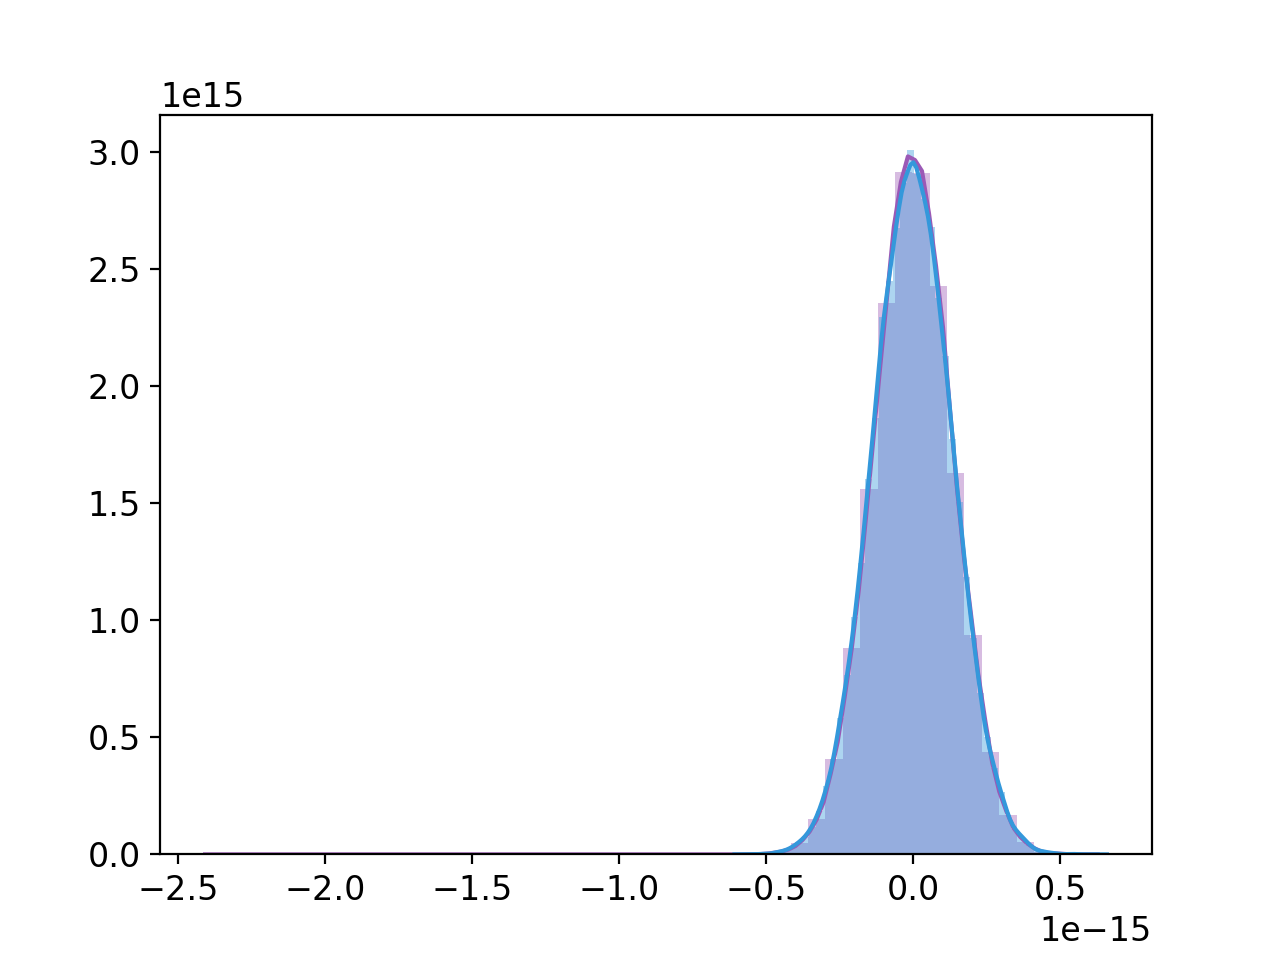

In [32]:
pl.figure()
sns.distplot(blobs_baseline[rlist_b].values.ravel())
sns.distplot(gratings_baseline[rlist_g].values.ravel())


# Set colors

In [27]:
visual_areas = ['V1', 'Lm', 'Li']
color_list = ['gray', 'cornflowerblue', 'darkorange']
area_colors = dict((v, c) for v, c in zip(visual_areas, color_list))

pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

# Set output dir

In [44]:
outdir = os.path.join(aggregate_dir, 'variability')
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

figid = '%s_%s_%s-thr-%.2f' % (traceid, response_type, responsive_test, responsive_thr)
print(figid)

/n/coxfs01/julianarhee/aggregate-visual-areas/variability
traces001_dff_ROC-thr-0.05


### Filter out ROIs that have bad stim placement

In [45]:
min_rois = 5
stim_on_key = {'blobs': 45, 'gratings': 45}
nframes_on_key = {'blobs':  45, 'gratings':  22}

SDF = {'blobs': blobs_sdf, 'gratings': gratings_sdf}
stimulus_configs = {'blobs': blobs_sdf[blobs_sdf['morphlevel']!=-1].index.tolist(),
                    'gratings': gratings_sdf[gratings_sdf['size'] != 200].index.tolist()}

In [46]:
for k, v in stimulus_configs.items():
    print(k, len(v))


('gratings', 32)
('blobs', 45)


In [47]:
wrong_epochs = ['20190511_JC083_fov1_gratings',
                '20190512_JC083_fov1_gratings',
                '20190513_JC078_fov1_gratings',
                '20190517_JC083_fov1_gratings'] #20190517_JC083_fov1_gratings

included_dsets=[]; incorrect_stim=[];
for curr_exp in ['blobs', 'gratings']:
    stim_on = stim_on_key[curr_exp]
    nframes_on = nframes_on_key[curr_exp]
    for (visual_area, animalid, session, fovnum), dgroup in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
        datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
        
        # Remove dsets with wrong epochs
        if '%s_%s' % (datakey, curr_exp) in wrong_epochs:
            print("-- skipping (%s) --" % datakey)
            continue
            
        # Remove dsets with wrong stimuli
        fov = 'FOV%i_zoom2p0x' % fovnum
        if curr_exp=='blobs':
            exp = util.Objects(animalid, session, fov, traceid=traceid)
        else:
            exp = util.Gratings(animalid, session, fov, traceid=traceid)
        curr_sdf = exp.get_stimuli()
        if curr_sdf.shape != SDF[curr_exp].shape:
            incorrect_stim.append('%s_%s' % (datakey, curr_exp))
            continue
            
        included_dsets.append(dgroup)
included_dsets = pd.concat(included_dsets, axis=0).drop_duplicates()

... [JC090|20190605|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
Getting stimulus info for: combined_blobs_static
... [JC091|20190602|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
Getting stimulus info for: combined_blobs_static
... [JC091|20190606|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
Getting stimulus info for: combined_blobs_static
... [JC091|20190607|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
Getting stimulus info for: combined_blobs_static
... [JC091|20190614|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
Getting stimulus info for: combined_blobs_static
... [JC091|20191008|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
Getting stimulus info for: combined_blobs_static
... [JC099|20190609|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
Getting stimulus info for: combined_blobs_static

In [48]:
dsets.shape, included_dsets.shape

((105, 6), (105, 6))

## Get roi counts

In [49]:
#overlap_thr = 0.2
min_rois = 5
overlap_levels = [0.1, 0.2, 0.3, 0.4, 0.5]

passrois={}
roicounts=[]
too_few=dict((v, []) for v in overlap_levels)

i=0
for overlap_thr in overlap_levels:
    for curr_exp in ['blobs', 'gratings']:
        for (visual_area, animalid, session, fovnum), g in included_dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
            datakey = '%s_%s_fov%i' % (session, animalid, fovnum)

            # Ignore sets with wrong epochs
            if '%s_%s' % (datakey, curr_exp) in wrong_epochs:
                print("-- %.1f skipping (%s, %s) --" % (overlap_thr, datakey, curr_exp))
                continue

            if '%s_%s' % (datakey, curr_exp) not in passrois.keys():
                passrois['%s_%s' % (datakey, curr_exp)] = {}

            if curr_exp == 'blobs':
                visual_rois = [int(r) for r in BLOBSDATA[datakey]['data'].columns if r != 'config']
            else:
                visual_rois = [int(r) for r in GRATINGSDATA[datakey]['data'].columns if r != 'config']

            # Get ROIs with RF fits and threshold by overlap-percentage
            meanoverlaps = overlaprois[overlaprois['datakey']==datakey].groupby(['rid']).mean()
            coverage_rois = meanoverlaps[meanoverlaps['overlap']>=overlap_thr].index.tolist()
            pass_rois_overlap = [r for r in coverage_rois if r in visual_rois]

            if len(pass_rois_overlap) < min_rois:
                #print("%s: skipping, too few ROIs pass %.2f overlap thr" % (datakey, overlap_thr))
                too_few[overlap_thr].append('%s_%s_%s' % (visual_area, datakey, curr_exp))
                continue

            passrois['%s_%s' % (datakey, curr_exp)].update({overlap_thr: pass_rois_overlap})
            roicounts.append(pd.DataFrame({'n_visual': len(visual_rois),
                                           'experiment': curr_exp,
                                           'overlap': overlap_thr,
                                           'n_pass_overlap': len(pass_rois_overlap),
                                           'pass_fraction': float(len(pass_rois_overlap))/len(visual_rois),
                                           'visual_area': visual_area,
                                           'datakey': datakey}, index=[i]))
            i+=1
roicounts = pd.concat(roicounts, axis=0)


-- 0.1 skipping (20190513_JC078_fov1, gratings) --
-- 0.1 skipping (20190512_JC083_fov1, gratings) --
-- 0.1 skipping (20190517_JC083_fov1, gratings) --
-- 0.1 skipping (20190511_JC083_fov1, gratings) --
-- 0.2 skipping (20190513_JC078_fov1, gratings) --
-- 0.2 skipping (20190512_JC083_fov1, gratings) --
-- 0.2 skipping (20190517_JC083_fov1, gratings) --
-- 0.2 skipping (20190511_JC083_fov1, gratings) --
-- 0.3 skipping (20190513_JC078_fov1, gratings) --
-- 0.3 skipping (20190512_JC083_fov1, gratings) --
-- 0.3 skipping (20190517_JC083_fov1, gratings) --
-- 0.3 skipping (20190511_JC083_fov1, gratings) --
-- 0.4 skipping (20190513_JC078_fov1, gratings) --
-- 0.4 skipping (20190512_JC083_fov1, gratings) --
-- 0.4 skipping (20190517_JC083_fov1, gratings) --
-- 0.4 skipping (20190511_JC083_fov1, gratings) --
-- 0.5 skipping (20190513_JC078_fov1, gratings) --
-- 0.5 skipping (20190512_JC083_fov1, gratings) --
-- 0.5 skipping (20190517_JC083_fov1, gratings) --
-- 0.5 skipping (20190511_JC083

### Plot N fovs that pass min rois and threshold requirements

In [51]:
roicounts.groupby(['overlap', 'visual_area', 'experiment']).count()

datakey  n_pass_overlap  n_visual  \
overlap visual_area experiment                                      
0.1     Li          blobs             9               9         9   
                    gratings          9               9         9   
        Lm          blobs             6               6         6   
                    gratings          3               3         3   
        V1          blobs             7               7         7   
                    gratings          6               6         6   
0.2     Li          blobs             9               9         9   
                    gratings          6               6         6   
        Lm          blobs             6               6         6   
                    gratings          3               3         3   
        V1          blobs             7               7         7   
                    gratings          6               6         6   
0.3     Li          blobs             8               8         8   
                    gratings          6               6         6   
        Lm          blobs             6               6         6   
                    gratings          3               3         3   
        V1          blobs             7               7         7   
                    gratings          6               6         6   
0.4     Li          blobs             5               5         5   
                    gratings          4               4         4   
        Lm          blobs             6               6         6   
                    gratings          3               3         3   
        V1          blobs             7               7         7   
                    gratings          6               6         6   
0.5     Li          blobs             1               1         1   
        Lm          blobs             6               6         6   
                    gratings          2               2         2   
        V1          blobs             7               7         7   
                    gratings          6               6         6   

                                pass_fraction  
overlap visual_area experiment                 
0.1     Li          blobs                   9  
                    gratings                9  
        Lm          blobs                   6  
                    gratings                3  
        V1          blobs                   7  
                    gratings                6  
0.2     Li          blobs                   9  
                    gratings                6  
        Lm          blobs                   6  
                    gratings                3  
        V1          blobs                   7  
                    gratings                6  
0.3     Li          blobs                   8  
                    gratings                6  
        Lm          blobs                   6  
                    gratings                3  
        V1          blobs                   7  
                    gratings                6  
0.4     Li          blobs                   5  
                    gratings                4  
        Lm          blobs                   6  
                    gratings                3  
        V1          blobs                   7  
                    gratings                6  
0.5     Li          blobs                   1  
        Lm          blobs                   6  
                    gratings                2  
        V1          blobs                   7  
                    gratings                6

<IPython.core.display.Javascript object>


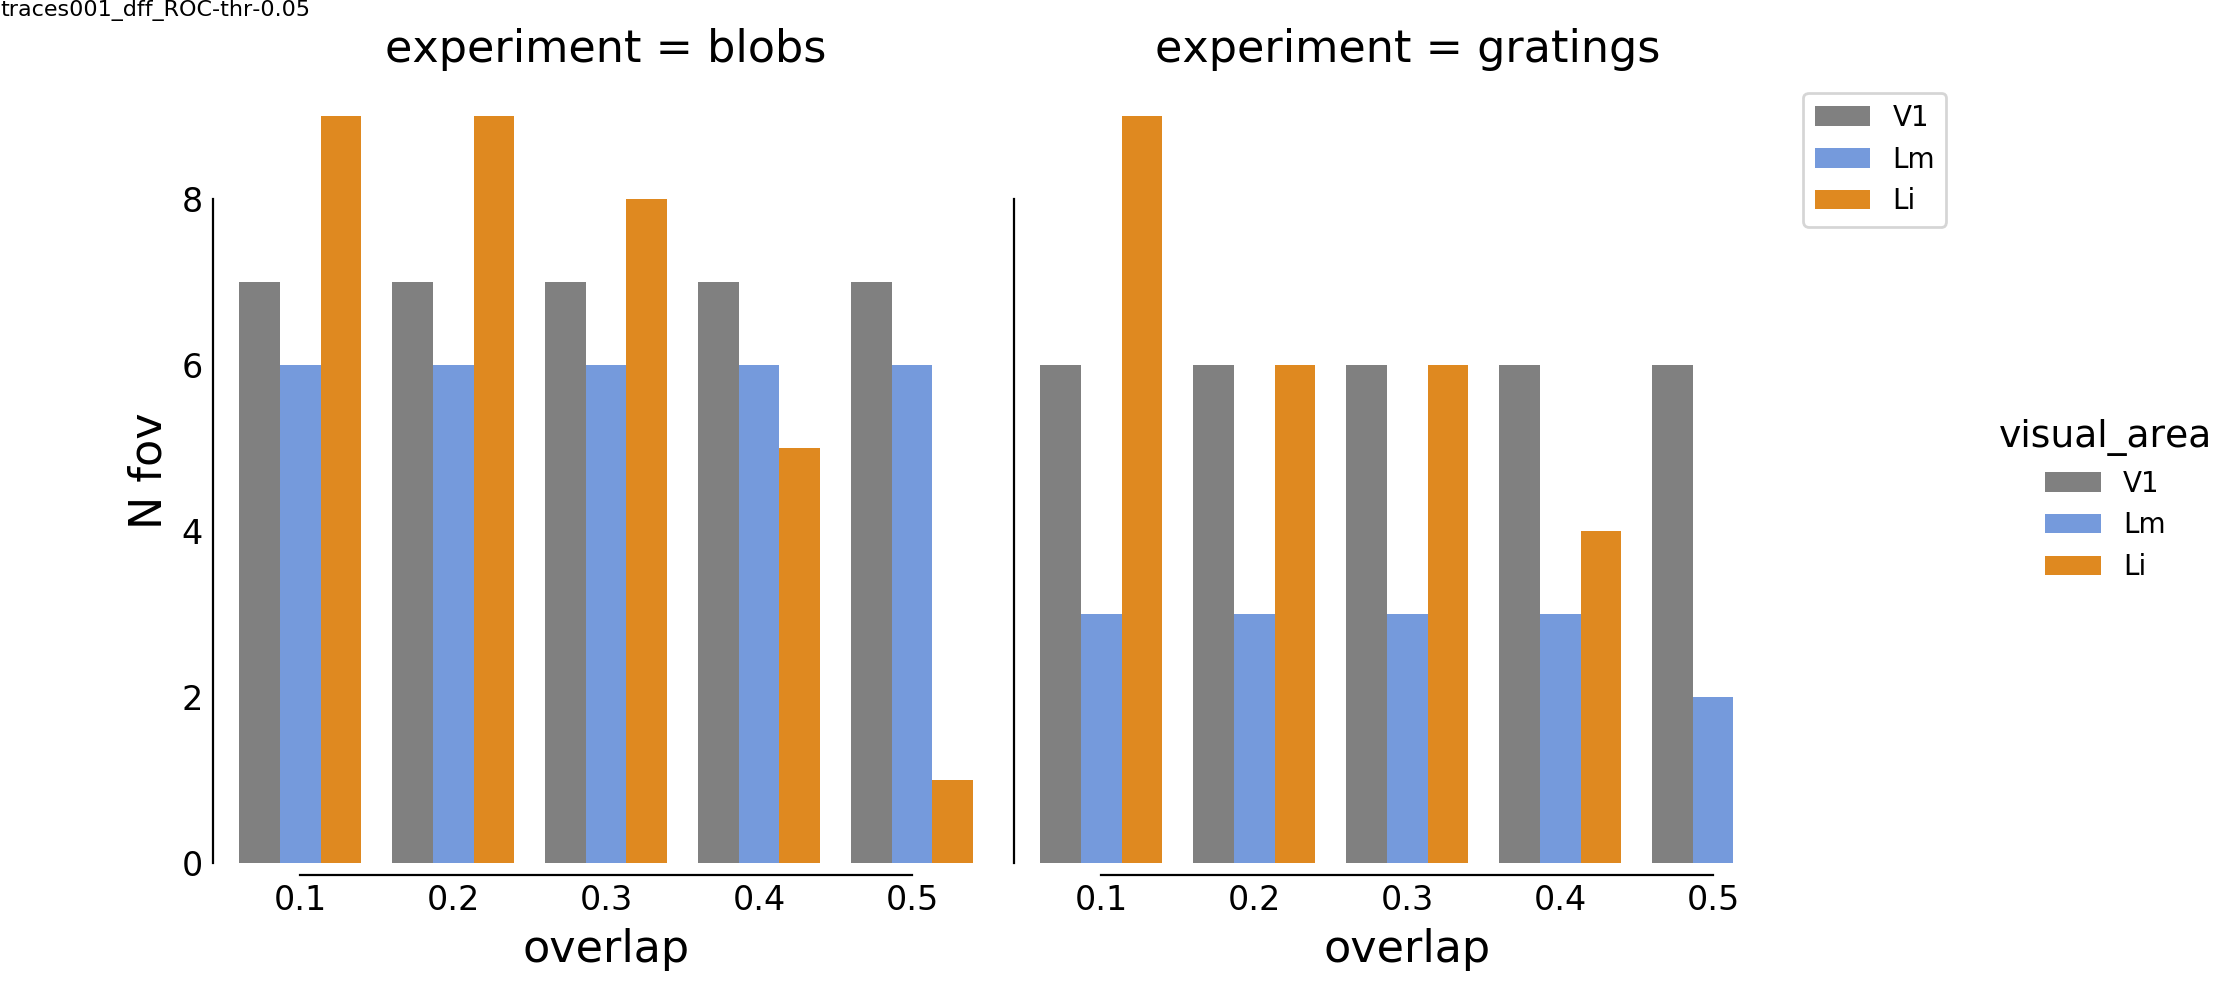

nFOVs_pass-overlap-thr_by-experiment__baseline
/n/coxfs01/julianarhee/aggregate-visual-areas/variability


In [52]:
pg = sns.catplot(x='overlap', hue='visual_area', col='experiment', data=roicounts, kind='count',
           palette=area_colors, hue_order=visual_areas)

sns.despine(trim=True, offset=4)
pl.subplots_adjust(left=0.1, right=0.8)
for ax in pg.axes.flat:
    ax.tick_params(axis='both', size=0)
pl.legend(bbox_to_anchor=(1.0,1))
pg.axes.flat[0].set_ylabel("N fov")


label_figure(pg.fig, figid)

figname = 'nFOVs_pass-overlap-thr_by-experiment_%s' % epoch_str
pl.savefig(os.path.join(outdir, '%s.svg' % figname))
print(figname)
print(outdir)


### Plot average num cells (per FOV) by overlap thr 

<IPython.core.display.Javascript object>


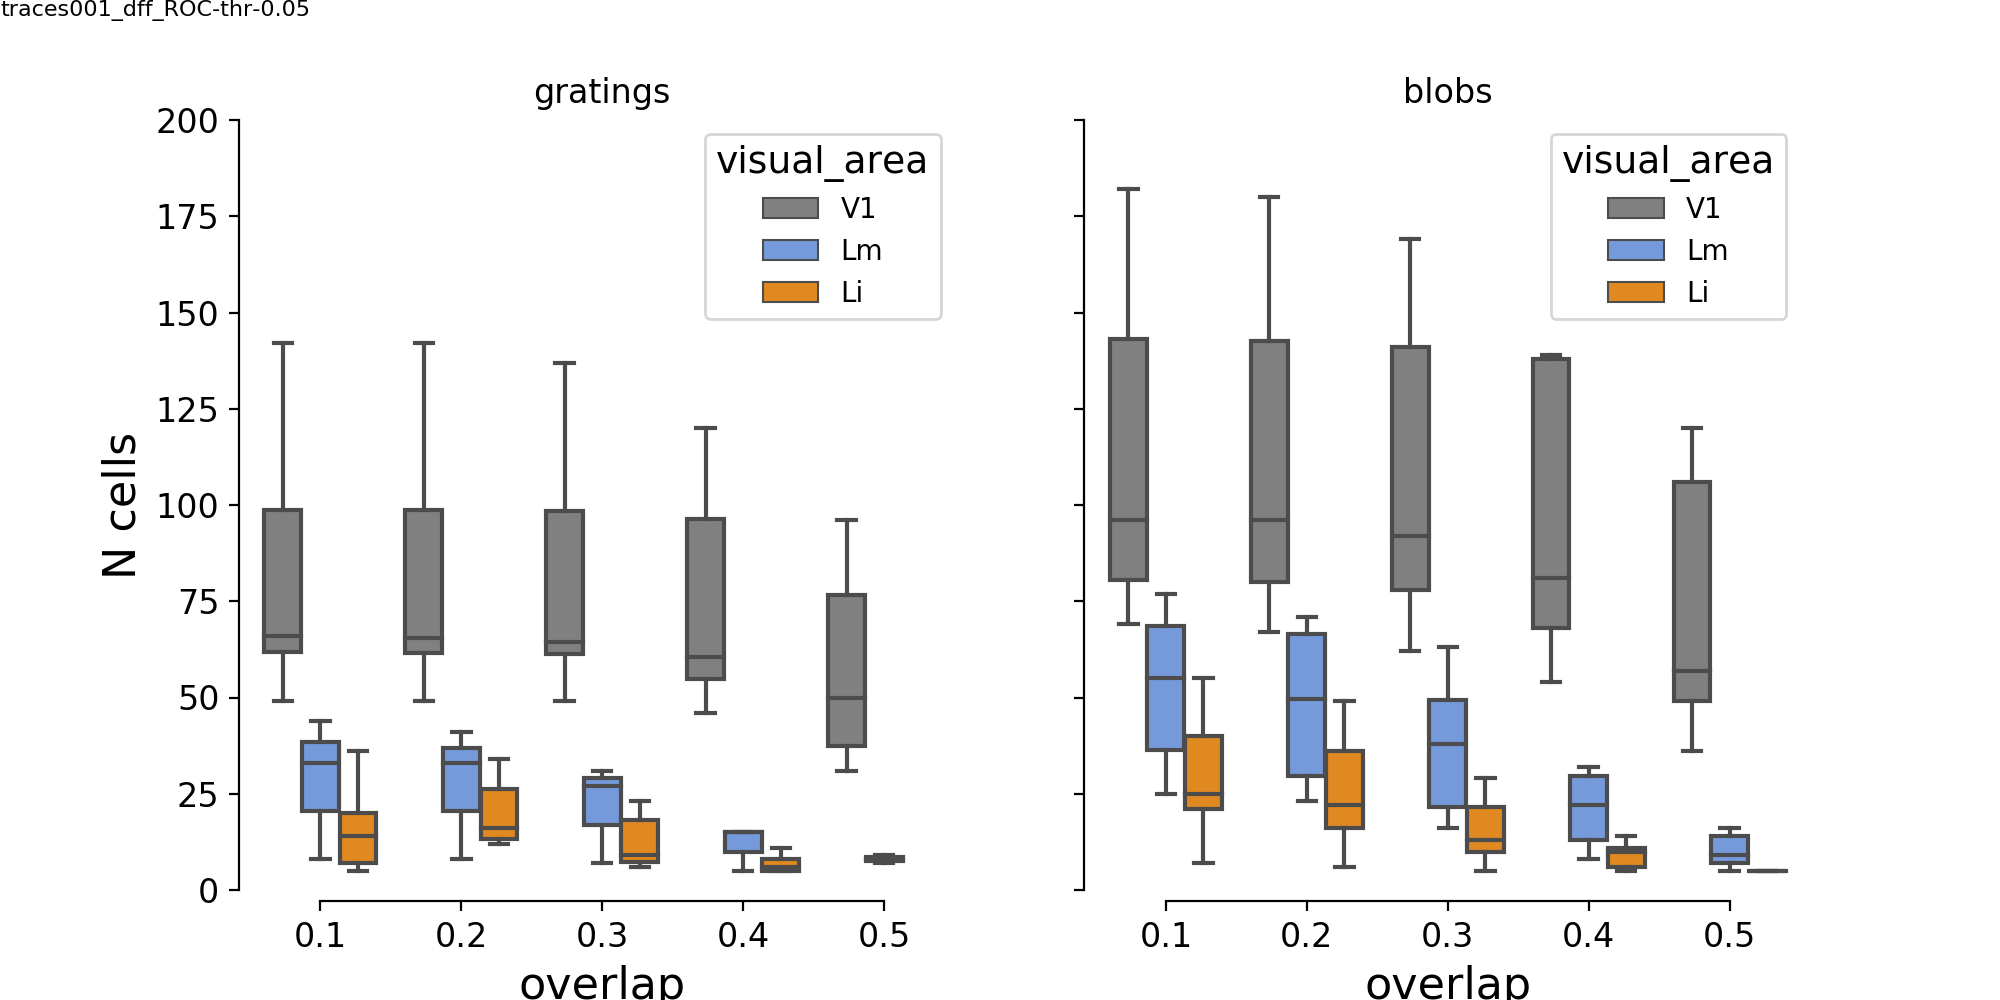

n-pass-overlap_by-exp_compare-thresholds_ROC


In [392]:


fig, axes = pl.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

for ai, (ax, curr_exp) in enumerate(zip(axes.flat, ['gratings', 'blobs'])):
    ax.set_title(curr_exp)
    sns.boxplot(x='overlap', hue='visual_area', y='n_pass_overlap', 
                data=roicounts[roicounts['experiment']==curr_exp], 
                ax=ax, palette=area_colors, hue_order=visual_areas, fliersize=5)
    #sns.swarmplot(x='visual_area', y='n_pass_overlap', data=roicounts[roicounts['experiment']==curr_exp], 
    #              ax=ax, color='k', order=visual_areas)
    ax.set_ylabel("N cells")
    if ai == 1:
        ax.set_ylabel("")
        
ax.set_ylim([0, 200])
sns.despine(trim=True, offset=4)
#pl.suptitle('Number of cells with overlap >= %.2f' % overlap_thr)

figname = 'n-pass-overlap_by-exp_compare-thresholds_%s' % (responsive_test)

label_figure(fig, figid)
print(figname)
pl.savefig(os.path.join(outdir, '%s.svg' % figname))
pl.savefig(os.path.join(outdir, '%s.png' % figname))

### Plot N cells that pass for 1 overlap level

<IPython.core.display.Javascript object>


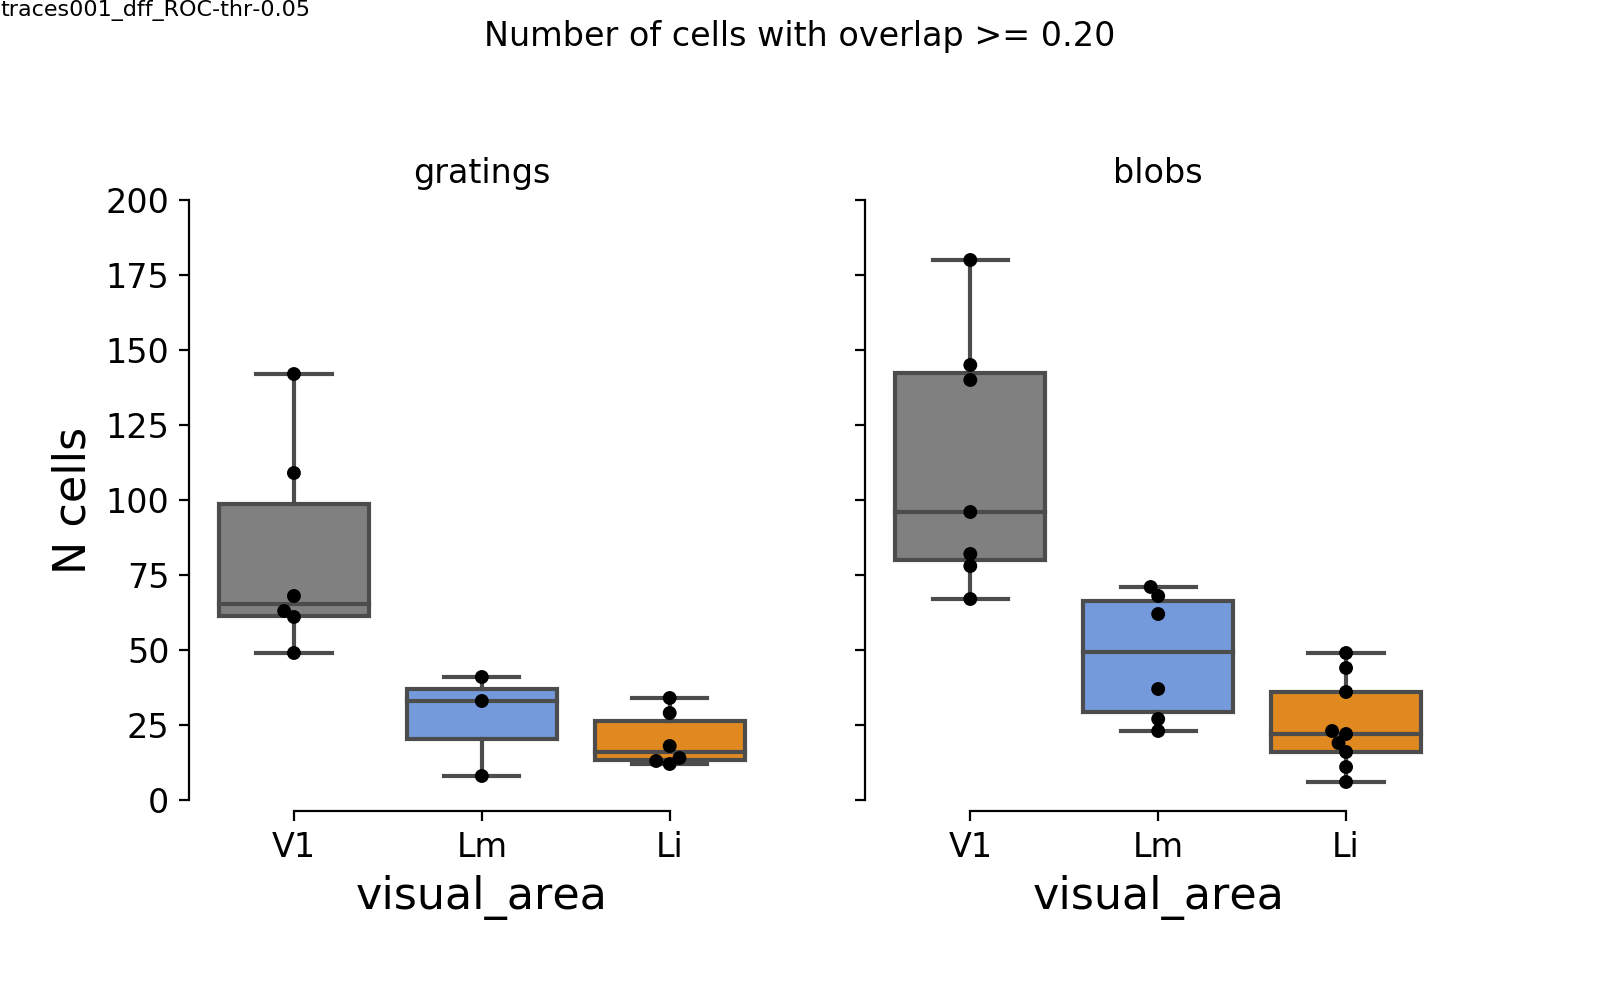

n-pass-overlap-thr-0.20_ROC


In [393]:
overlap_thr=0.2
rcounts = roicounts[roicounts['overlap']==overlap_thr]

fig, axes = pl.subplots(1, 2, figsize=(8, 5), sharex=True, sharey=True)
for ai, (ax, curr_exp) in enumerate(zip(axes.flat, ['gratings', 'blobs'])):
    ax.set_title(curr_exp)
    sns.boxplot(x='visual_area', y='n_pass_overlap', data=rcounts[rcounts['experiment']==curr_exp], 
                ax=ax, palette=area_colors, order=visual_areas, fliersize=0)
    
    sns.swarmplot(x='visual_area', y='n_pass_overlap', data=rcounts[rcounts['experiment']==curr_exp], 
                  ax=ax, color='k', order=visual_areas)
    ax.set_ylabel("N cells")
    if ai == 1:
        ax.set_ylabel("")
        
ax.set_ylim([0, 200])
sns.despine(trim=True, offset=4)
pl.subplots_adjust(top=0.8, bottom=0.2)
pl.suptitle('Number of cells with overlap >= %.2f' % overlap_thr)

figname = 'n-pass-overlap-thr-%.2f_%s' % (overlap_thr, responsive_test)

label_figure(fig, figid)
print(figname)
pl.savefig(os.path.join(outdir, '%s.svg' % figname))
pl.savefig(os.path.join(outdir, '%s.png' % figname))

### Plot fraction of visual cells that pass overlap thr

<IPython.core.display.Javascript object>


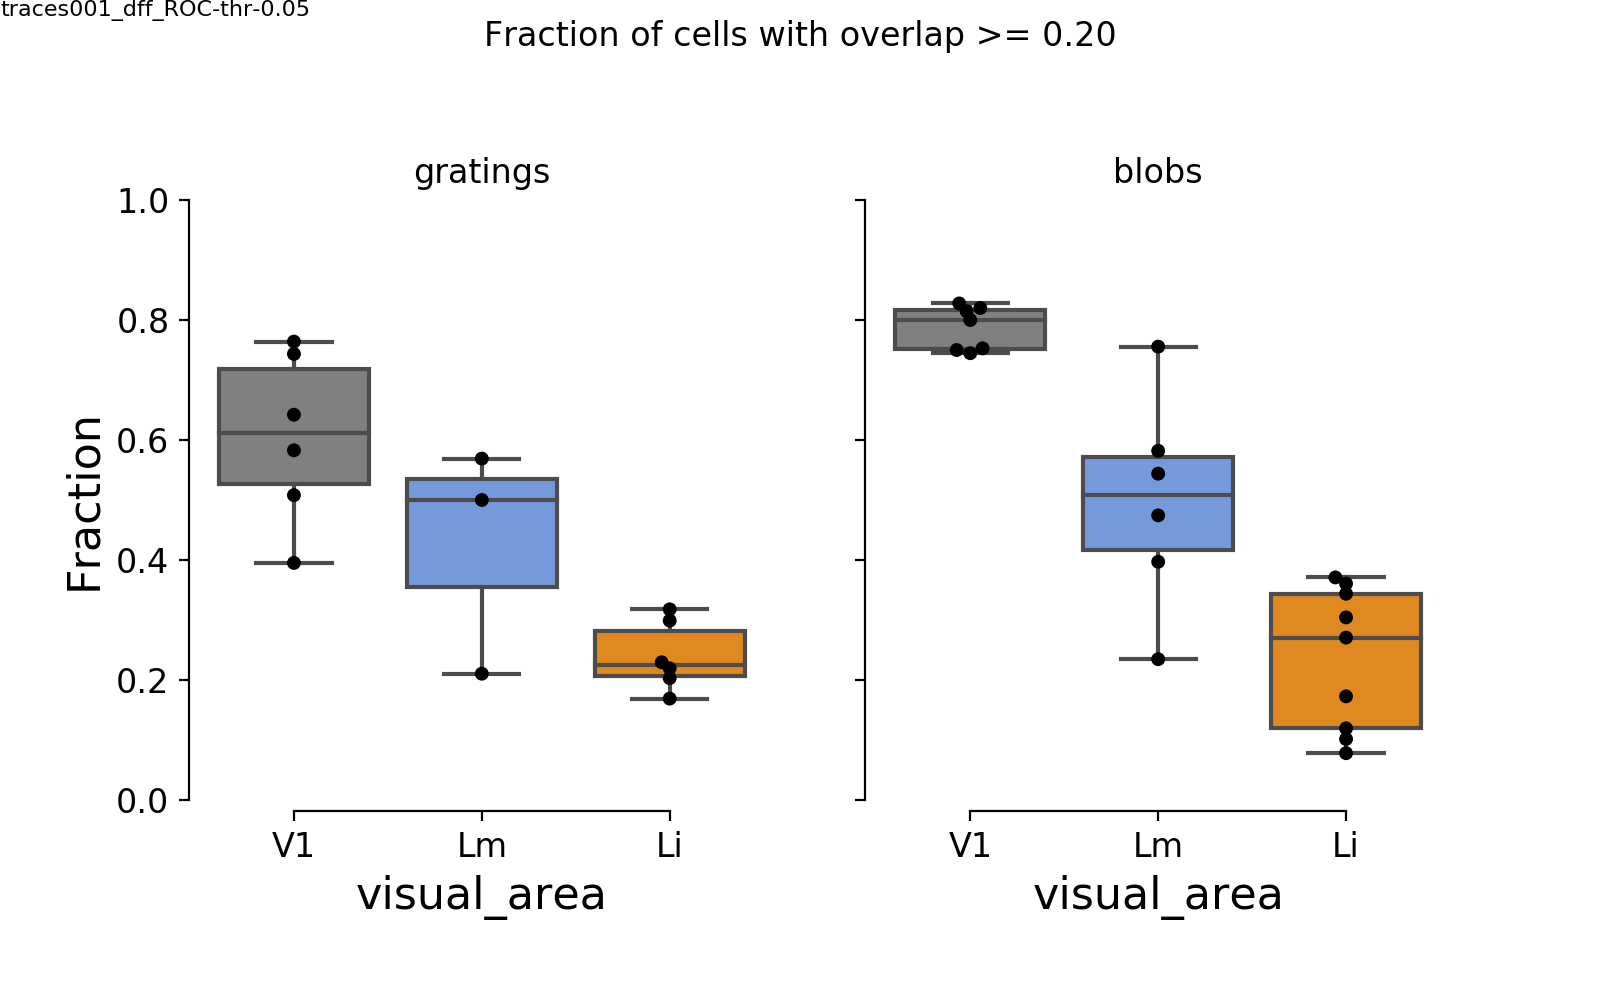

frac-pass-overlap-thr-0.20_ROC


In [394]:
overlap_thr=0.2
rcounts = roicounts[roicounts['overlap']==overlap_thr]

fig, axes = pl.subplots(1, 2, figsize=(8, 5), sharex=True, sharey=True)
for ai, (ax, curr_exp) in enumerate(zip(axes.flat, ['gratings', 'blobs'])):
    ax.set_title(curr_exp)
    sns.boxplot(x='visual_area', y='pass_fraction', data=rcounts[rcounts['experiment']==curr_exp], 
                ax=ax, palette=area_colors, order=visual_areas, fliersize=0)
    
    sns.swarmplot(x='visual_area', y='pass_fraction', data=rcounts[rcounts['experiment']==curr_exp], 
                  ax=ax, color='k', order=visual_areas)
    ax.set_ylabel("Fraction")
    if ai == 1:
        ax.set_ylabel("")
        
ax.set_ylim([0, 1])
sns.despine(trim=True, offset=4)
pl.subplots_adjust(top=0.8, bottom=0.2)
pl.suptitle('Fraction of cells with overlap >= %.2f' % overlap_thr)

figname = 'frac-pass-overlap-thr-%.2f_%s' % (overlap_thr, responsive_test)

label_figure(fig, figid)
print(figname)
pl.savefig(os.path.join(outdir, '%s.svg' % figname))
pl.savefig(os.path.join(outdir, '%s.png' % figname))

# Load mean trace for all datasets

In [38]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/responsivity'

In [185]:
filter_configs = True

if filter_configs:
    meantrace_dfile = os.path.join(outdir, 'meantrace_popn_imagestimuli.pkl')
else:
    meantrace_dfile = os.path.join(outdir, 'meantrace_popn_allstimuli.pkl')

load_alldata = False
if os.path.exists(meantrace_dfile):
    with open(meantrace_dfile, 'rb') as f:
        tdf = pkl.load(f)
else:
    load_alldata = True
    

In [396]:
sorted(passrois.keys(), key=natural_keys)

['20190511_JC083_fov1_blobs',
 '20190512_JC083_fov1_blobs',
 '20190513_JC078_fov1_blobs',
 '20190517_JC083_fov1_blobs',
 '20190522_JC084_fov1_blobs',
 '20190522_JC084_fov1_gratings',
 '20190525_JC084_fov1_blobs',
 '20190525_JC084_fov1_gratings',
 '20190602_JC091_fov1_blobs',
 '20190602_JC091_fov1_gratings',
 '20190603_JC080_fov1_blobs',
 '20190603_JC080_fov1_gratings',
 '20190605_JC090_fov1_blobs',
 '20190605_JC090_fov1_gratings',
 '20190606_JC091_fov1_blobs',
 '20190606_JC091_fov1_gratings',
 '20190607_JC091_fov1_blobs',
 '20190607_JC091_fov1_gratings',
 '20190609_JC099_fov1_blobs',
 '20190609_JC099_fov1_gratings',
 '20190612_JC099_fov1_blobs',
 '20190612_JC099_fov1_gratings',
 '20190613_JC097_fov1_blobs',
 '20190613_JC097_fov1_gratings',
 '20190614_JC091_fov1_blobs',
 '20190614_JC091_fov1_gratings',
 '20190616_JC097_fov1_blobs',
 '20190616_JC097_fov1_gratings',
 '20190617_JC097_fov1_blobs',
 '20190617_JC097_fov1_gratings',
 '20190617_JC099_fov1_blobs',
 '20190617_JC099_fov1_gratings'

In [397]:
skip = []; skip_thr = [];

tracedf = []
incorrect_alignment = {}

if load_alldata:
    
    for curr_exp in ['blobs', 'gratings']:
        stim_on = stim_on_key[curr_exp]
        nframes_on = nframes_on_key[curr_exp]
        
        for (visual_area, animalid, session, fovnum), dgroup in included_dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
            datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
            if '%s_%s' % (datakey, curr_exp) not in passrois.keys():
                skip.append('%s_%s' % (datakey, curr_exp))
                print("skipping datakey: %s" % '%s_%s' % (datakey, curr_exp))
                continue

            #### Load traces of responsive cells
            traces, labels, sdf = load_traces(animalid, session, fovnum, curr_exp, traceid=traceid, response_type=response_type,
                                                responsive_test=responsive_test, responsive_thr=responsive_thr)

            if labels['stim_on_frame'].unique()[0] != stim_on or labels['nframes_on'].unique()[0] != nframes_on:
                incorrect_alignment.update({'%s_%s' % (datakey, curr_exp): 
                                                      {'stim_on': float(labels['stim_on_frame'].unique()),
                                                      'nframes_on': float(labels['nframes_on'].unique())}})
                print("... %s: incorrect, skipping." % datakey)
                continue
                
            traces['trial'] = labels['trial'].copy()
            traces['config'] = labels['config'].copy()
            if filter_configs:
                included_configs = stimulus_configs[curr_exp]
                df = traces[traces['config'].isin(included_configs)].copy()
            else:
                df = traces.copy()
                
            for overlap_thr in overlap_levels:
                if overlap_thr not in passrois['%s_%s' % (datakey, curr_exp)]:
                    skip_thr.append('%s_%s_%.2f' % (datakey, curr_exp, overlap_thr))
                    print("... skipping thr: ", '%s_%s_%.2f' % (datakey, curr_exp, overlap_thr))
                    continue

                rois_objects = passrois['%s_%s' % (datakey, curr_exp)][overlap_thr]
                mean_trace = np.nanmean(np.vstack([np.nanmean(g[rois_objects], axis=1) for t, g in df.groupby(['trial'])]), axis=0)
                nt = len(mean_trace)

                tracedf.append(pd.DataFrame({'trace': mean_trace,
                                             'overlap': [overlap_thr for _ in np.arange(0, nt)],
                                             'visual_area': [visual_area for _ in np.arange(0, nt)],
                                             'datakey': [datakey for _ in np.arange(0, nt)],
                                             'experiment': [curr_exp for _ in np.arange(0, nt)]}))
            del df
            
    tdf = pd.concat(tracedf, axis=0)

    # Save
    with open(meantrace_dfile, 'wb') as f:
        pkl.dump(tdf, f, protocol=pkl.HIGHEST_PROTOCOL)

... [JC090|20190605|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... loading data array
/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_5afb30_traces001_ea6bc7_traces001_9747d8_traces001_70031f_traces001_ba4282_traces001_c2eec5_traces001_5c088e/data_arrays/np_subtracted.npz
NP_subtracted offset was: 12.62
adding NP offset... (NP baseline offset: 524.30)
((220725, 271), (271,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_5afb30_traces001_ea6bc7_traces001_9747d8_traces001_70031f_traces001_ba4282_traces001_c2eec5_traces001_5c088e/summary_stats/ROC/roc_results.pkl']


/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice


('... skipping thr: ', '20190605_JC090_fov1_blobs_0.40')
('... skipping thr: ', '20190605_JC090_fov1_blobs_0.50')
... [JC091|20190602|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... loading data array
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_573669_traces001_3d2687_traces001_17838a_traces001_452178_traces001_c84a17_traces001_faae98/data_arrays/np_subtracted.npz
NP_subtracted offset was: 62.92
adding NP offset... (NP baseline offset: 372.48)
((202365, 356), (356,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_573669_traces001_3d2687_traces001_17838a_traces001_452178_traces001_c84a17_traces001_faae98/summary_stats/ROC/roc_results.pkl']
... [JC091|20190606|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... loading data array
/n/coxfs01/2p-

NP_subtracted offset was: 127.59
adding NP offset... (NP baseline offset: 1464.16)
((182115, 234), (234,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC117/20191105/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_1621ed_traces001_99712e_traces001_498354_traces001_92ea72_traces001_e3ab25_traces001_a2c0dd/summary_stats/ROC/roc_results.pkl']
('... skipping thr: ', '20191105_JC117_fov1_blobs_0.10')
('... skipping thr: ', '20191105_JC117_fov1_blobs_0.20')
('... skipping thr: ', '20191105_JC117_fov1_blobs_0.30')
('... skipping thr: ', '20191105_JC117_fov1_blobs_0.40')
('... skipping thr: ', '20191105_JC117_fov1_blobs_0.50')
... [JC120|20191111|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... loading data array
/n/coxfs01/2p-data/JC120/20191111/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_603e33_traces001_b209e8_traces001_0b0a19_traces001_67c45c_traces001_8513ce_trace

((202500, 389), (389,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_6da5ed_traces001_19b5de_traces001_565a1c_traces001_238b5b_traces001_cb35ec_traces001_6537ce/summary_stats/ROC/roc_results.pkl']
... [JC097|20190613|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... loading data array
/n/coxfs01/2p-data/JC097/20190613/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_b92766_traces001_02482e_traces001_b1d533_traces001_f15eef_traces001_ccd355_traces001_b8ae95/data_arrays/np_subtracted.npz
NP_subtracted offset was: 156.56
adding NP offset... (NP baseline offset: 695.61)
((202500, 225), (225,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC097/20190613/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_b92766_traces001_02482e_

... getting data paths - name: gratings
... loading data array
/n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_3df331_traces001_4f5354_traces001_97e1ee_traces001_2625ca/data_arrays/np_subtracted.npz
NP_subtracted offset was: -15.30
adding NP offset... (NP baseline offset: 405.68)
((143360, 311), (311,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_gratings_static
['/n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_3df331_traces001_4f5354_traces001_97e1ee_traces001_2625ca/summary_stats/ROC/roc_results.pkl']
('... skipping thr: ', '20190609_JC099_fov1_gratings_0.50')
... [JC099|20190612|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... loading data array
/n/coxfs01/2p-data/JC099/20190612/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_0b642c_traces001_eaaf9d_traces001_d97b36_traces001_2d4a72/data_arrays/np_subtracted.

... [JC085|20190622|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... loading data array
/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_d50dee_traces001_dda9d2_traces001_bc8001_traces001_6b799c/data_arrays/np_subtracted.npz
NP_subtracted offset was: 17.11
adding NP offset... (NP baseline offset: 490.44)
((143360, 389), (389,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_gratings_static
['/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_d50dee_traces001_dda9d2_traces001_bc8001_traces001_6b799c/summary_stats/ROC/roc_results.pkl']
... [JC097|20190613|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... loading data array
/n/coxfs01/2p-data/JC097/20190613/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_c09a6a_traces001_b5507e_traces001_c49401_traces001_446964/data_arrays/np_subtracted.n

In [398]:
print(tdf.shape)
print(meantrace_dfile)

(21703, 5)
/n/coxfs01/julianarhee/aggregate-visual-areas/responsivity/meantrace_popn_imagestimuli.pkl


In [399]:
incorrect_alignment

{}

In [412]:
tdf[['visual_area', 'experiment', 'datakey']].drop_duplicates().groupby(['visual_area', 'experiment']).count()

datakey
visual_area experiment         
Li          blobs             9
            gratings          9
Lm          blobs             6
            gratings          3
V1          blobs             7
            gratings          6

### Plot average popn trace

In [401]:
stim_str = 'images' if filter_configs else 'allconds'

In [405]:
curr_exp = 'gratings'
overlap_thr = 0.2

#currtdf = tdf[ (tdf['overlap']==overlap_thr) & (tdf['datakey'].isin(ok_np_keys)) ].copy()
currtdf = tdf[tdf['overlap']==overlap_thr].copy()

nframes_trial = stim_on_key[curr_exp]*2 + nframes_on_key[curr_exp]
traces_by = dict((visual_area, []) for visual_area in visual_areas)
traces_names = dict((visual_area, []) for visual_area in visual_areas)
for (visual_area, dkey), g in currtdf[currtdf['experiment']==curr_exp].groupby(['visual_area', 'datakey']):
    traces_by[visual_area].append(g['trace'].values[0:nframes_trial])
    traces_names[visual_area].append(dkey)
    

<IPython.core.display.Javascript object>


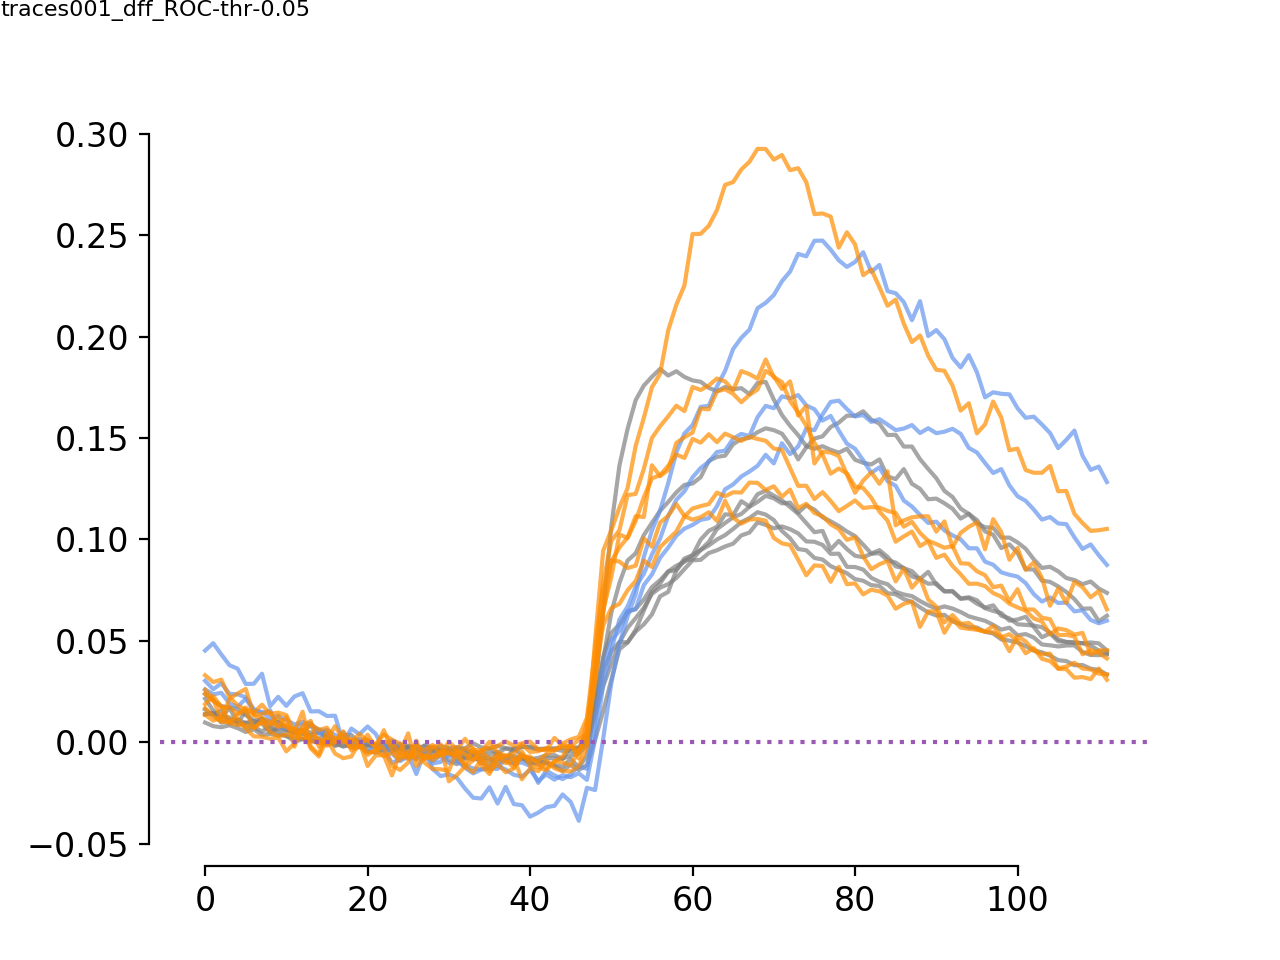

avg-popn-tcourse_by-fov_overlap-0.20_min-nrois-5_ROC_gratings-images


In [406]:
fig, ax = pl.subplots()
for visual_area, tmat in traces_by.items():
    for vs in tmat:
        ax.plot(vs, color=area_colors[visual_area], alpha=0.7)
sns.despine(trim=True, offset=4)
label_figure(fig, figid)
ax.axhline(y=0, ls=':')

figname = 'avg-popn-tcourse_by-fov_overlap-%.2f_min-nrois-%i_%s_%s-%s' % (overlap_thr, min_rois, responsive_test, curr_exp, stim_str)
print(figname)
pl.savefig(os.path.join(outdir, '%s.svg' % figname))
pl.savefig(os.path.join(outdir, '%s.png' % figname))

<IPython.core.display.Javascript object>


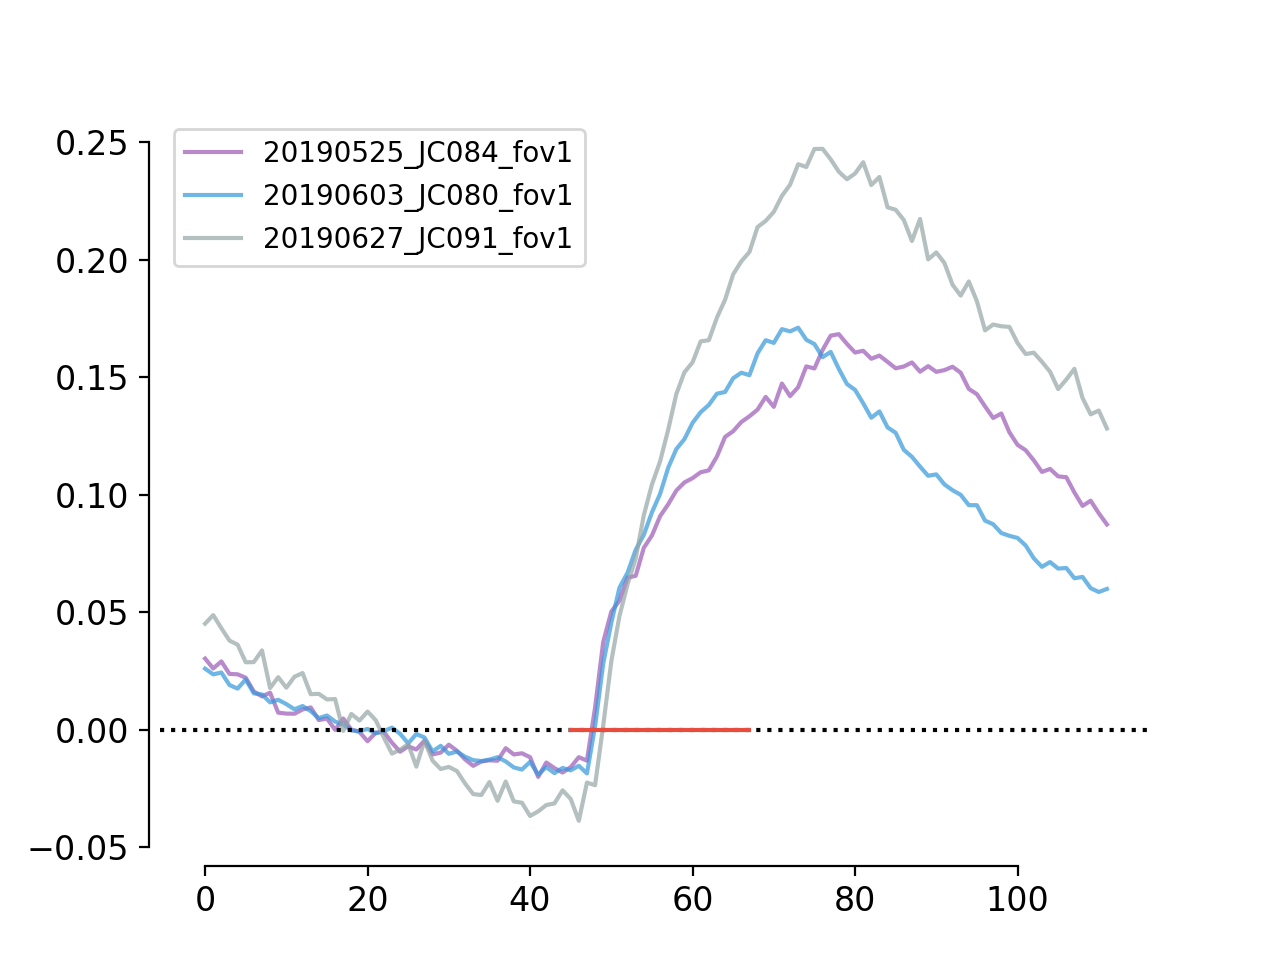

In [407]:
fig, ax = pl.subplots()
for visual_area, tmat in traces_by.items():
    if visual_area != 'Lm':
        continue
    for vi, vs in zip(traces_names[visual_area], tmat):
        ax.plot(vs, alpha=0.7, label=vi)
sns.despine(trim=True, offset=4)
ax.axhline(y=0, ls=':', color='k')
ax.plot([stim_on_key[curr_exp], stim_on_key[curr_exp]+nframes_on_key[curr_exp]],
       [0, 0])
ax.legend()

#### Plot as mean +/- sem

In [356]:
# These have incorrect stimulus duration (1s, instead of 0.5 s)
# * 20190513_JC078_fov1_gratings
# * 20190512_JC083_fov1_gratings
# * 20190511_JC083_fov1_gratings

# These have incorrect ITI (1s instead of 2s):
# * 20190517_JC083_fov1_gratings


wrong_stim = ['20190513_JC078_fov1', '20190512_JC083_fov1', '20190511_JC083_fov1', '20190517_JC083_fov1']
#ok_np_keys = [t for t in tdf['datakey'].unique() if t not in fix_np_keys and t not in wrong_stim]
ok_np_keys = [t for t in tdf['datakey'].unique() if t not in wrong_stim]

In [357]:
currtdf['datakey'].unique()

array(['20190605_JC090_fov1', '20190602_JC091_fov1', '20190606_JC091_fov1',
       '20190607_JC091_fov1', '20190614_JC091_fov1', '20191008_JC091_fov1',
       '20190609_JC099_fov1', '20190612_JC099_fov1', '20191018_JC113_fov1',
       '20190513_JC078_fov1', '20190603_JC080_fov1', '20190512_JC083_fov1',
       '20190517_JC083_fov1', '20190525_JC084_fov1', '20190627_JC091_fov1',
       '20190511_JC083_fov1', '20190522_JC084_fov1', '20190622_JC085_fov1',
       '20190613_JC097_fov1', '20190616_JC097_fov1', '20190617_JC097_fov1',
       '20191006_JC110_fov1'], dtype=object)

<IPython.core.display.Javascript object>


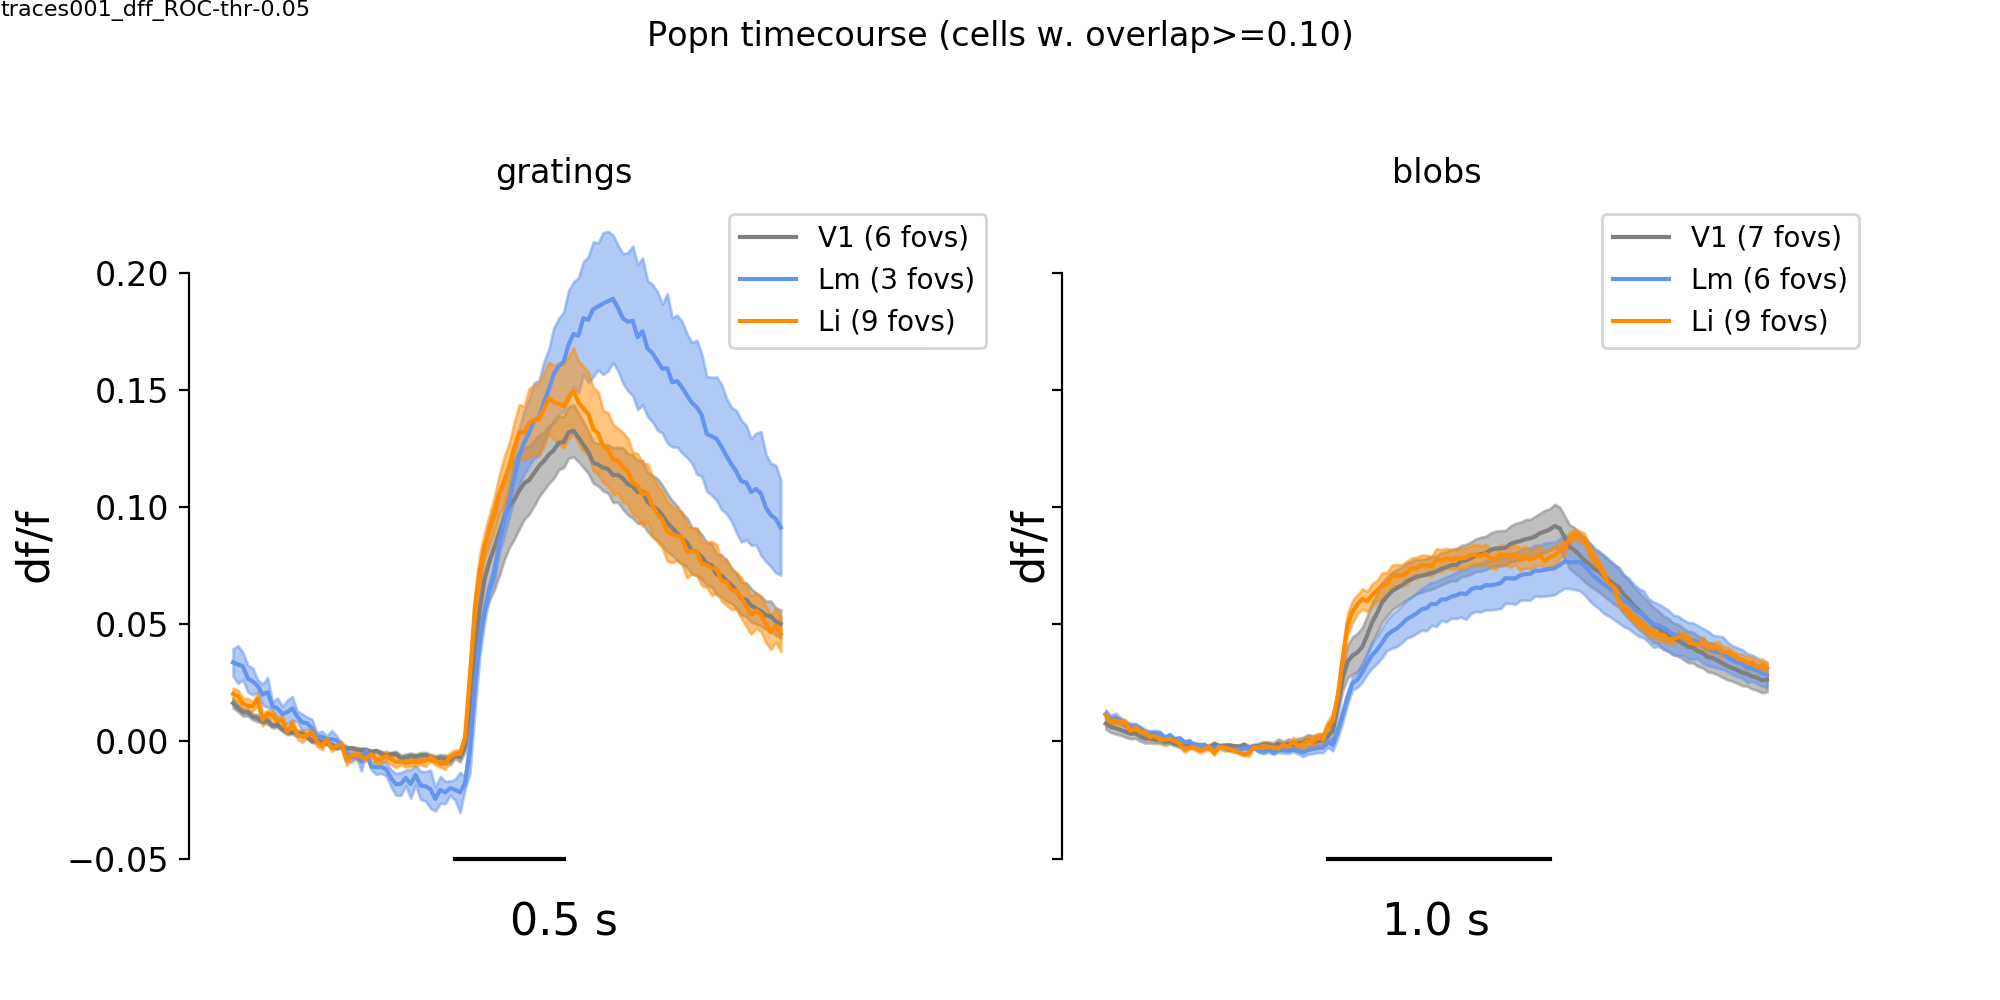

(0.5, 22)
(1.0, 45)
avg-popn-tcourse_overlap-0.10_min-nrois-5_ROC_blobs-images


In [415]:
yval = -0.05
overlap_thr = 0.1

currtdf = tdf[ (tdf['overlap']==overlap_thr) ]
#currtdf = tdf[ (tdf['overlap']==overlap_thr) & (tdf['datakey'].isin(ok_np_keys)) ].copy()
#currtdf = currtdf[currtdf['datakey'].isin(fix_np_keys)]

fig, axes = pl.subplots(1,2,figsize=(10, 5), sharex=True, sharey=True)
for ax, curr_exp in zip(axes.flat, ['gratings', 'blobs']):

    nframes_trial = stim_on_key[curr_exp]*2 + nframes_on_key[curr_exp]
    traces_by = dict((visual_area, []) for visual_area in visual_areas)
    for (visual_area, dkey), g in currtdf[currtdf['experiment']==curr_exp].groupby(['visual_area', 'datakey']):
        traces_by[visual_area].append(g['trace'].values[0:nframes_trial])
        
    stim_on = stim_on_key[curr_exp]
    nframes_on = nframes_on_key[curr_exp]
    for visual_area, tmat in traces_by.items():
        if len(tmat)==0:
            continue
        meantrace = np.array(tmat).mean(axis=0)
        stdtrace = spstats.sem(np.array(tmat), axis=0)
        ax.plot(meantrace, color=area_colors[visual_area], alpha=1, 
                label='%s (%i fovs)' % (visual_area, len(tmat)))
        nt = len(meantrace)
        ax.fill_between(np.arange(0, nt), meantrace-stdtrace, meantrace+stdtrace, 
                        color=area_colors[visual_area], alpha=0.5)

    ax.plot([stim_on, stim_on+nframes_on], [yval, yval], 'k')
    nsec_on = round(nframes_on/44.65, 1)
    print(nsec_on, nframes_on)
    ax.set_ylabel('df/f')
    ax.set_xlabel('%.1f s' % nsec_on)
    ax.set_xticklabels([])
    ax.set_xticks([])
    sns.despine(bottom=True, offset=4, trim=True)
    ax.set_title(curr_exp)
    ax.legend(bbox_to_anchor=(1.1, 1))

pl.suptitle('Popn timecourse (cells w. overlap>=%.2f)' % overlap_thr)
pl.subplots_adjust(left=0.1, wspace=0.2, top=0.8)

label_figure(fig, figid)
figname = 'avg-popn-tcourse_overlap-%.2f_min-nrois-%i_%s_%s-%s' % (overlap_thr, min_rois, responsive_test, curr_exp, stim_str)
print(figname)
pl.savefig(os.path.join(outdir, '%s.svg' % figname))
pl.savefig(os.path.join(outdir, '%s.png' % figname))

#### Why is it negative for gratings pre...

In [283]:
infokeys = ['iti_pre', 'iti_post', 'iti_full']

In [285]:
currdsets = included_dsets[included_dsets['experiment']=='gratings']
paramsdf=[]
i=0
for (animalid, session, fovnum), dgroup in currdsets.groupby(['animalid', 'session', 'fovnum']):
    datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
    paramfiles = sorted(glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_zoom2p0x' % fovnum, 'gratings_run*', 
                          'traces', '%s*' % traceid, 'event_alignment.json')), key=natural_keys)
    for pfile in paramfiles:
        with open(pfile, 'r') as f:
            params = json.load(f)
        pdict = dict((k, float(params[k])) for k in infokeys)
        pdict.update({'datakey': datakey})
        paramsdf.append(pd.DataFrame(pdict, index=[i]))
        i+=1
        
paramsdf = pd.concat(paramsdf, axis=0)

In [291]:
paramsdf[paramsdf['iti_full'] != 2]


,datakey,iti_full,iti_post,iti_pre
4,20190517_JC083_fov1,1.0,1.0,1.0
5,20190517_JC083_fov1,1.0,1.0,1.0
6,20190517_JC083_fov1,1.0,1.0,1.0
7,20190517_JC083_fov1,1.0,1.0,1.0


In [292]:
infokeys = ['quantile', 'window_size_sec', 'np_correction_factor', 'np_niterations']

In [298]:
currdsets = included_dsets[included_dsets['experiment']=='blobs']
paramsdf=[]
i=0
for (animalid, session, fovnum), dgroup in currdsets.groupby(['animalid', 'session', 'fovnum']):
    datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
    paramfiles = sorted(glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_zoom2p0x' % fovnum, 'blobs_run*', 
                          'traces', '%s*' % traceid, 'extraction_params.json')), key=natural_keys)
    for pfile in paramfiles:
        with open(pfile, 'r') as f:
            params = json.load(f)
        pdict = dict((k, float(params[k])) for k in infokeys)
        pdict.update({'datakey': datakey})
        paramsdf.append(pd.DataFrame(pdict, index=[i]))
        i+=1
        
paramsdf = pd.concat(paramsdf, axis=0)

In [320]:
fix_np_keys = paramsdf[paramsdf['np_niterations']!=10]['datakey'].unique()
fixd=[]
for (animalid, session, fovnum), dgroup in currdsets.groupby(['animalid', 'session', 'fovnum']):
    dkey = '%s_%s_FOV%i_zoom2p0x' % (animalid, session, fovnum)
    if dkey in fixp1:
        fixd.append(dgroup)
fixd = pd.concat(fixd, axis=0)


In [321]:
fixd.groupby(['visual_area']).count()

,animalid,experiment,fov,session,fovnum
visual_area,,,,,
Li,8,8,8,8,8
Lm,6,6,6,6,6
V1,6,6,6,6,6


In [325]:
fix_np_keys

array(['20190513_JC078_fov1', '20190603_JC080_fov1', '20190511_JC083_fov1',
       '20190512_JC083_fov1', '20190517_JC083_fov1', '20190522_JC084_fov1',
       '20190525_JC084_fov1', '20190622_JC085_fov1', '20190605_JC090_fov1',
       '20190602_JC091_fov1', '20190606_JC091_fov1', '20190607_JC091_fov1',
       '20190614_JC091_fov1', '20190627_JC091_fov1', '20190613_JC097_fov1',
       '20190616_JC097_fov1', '20190617_JC097_fov1', '20190609_JC099_fov1',
       '20190612_JC099_fov1', '20190617_JC099_fov1'], dtype=object)

# Baseline

In [61]:
overlap_thr=0.2
curr_exp = 'blobs'
bas=[]
for (visual_area, animalid, session, fovnunm), dgroup in included_dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
    roikey = '%s_%s' % (datakey, curr_exp)
    if roikey not in passrois or len(passrois[roikey])==0:
        print("- skipping %s" % roikey)
        continue
    curr_rois = passrois[roikey][overlap_thr]
    pre_vals = BLOBSDATA[datakey]['data'][curr_rois].values.ravel()
     
    bas.append(pd.DataFrame({'bas': pre_vals,
                  'visual_area': [visual_area for _ in np.arange(0, len(pre_vals))]}))

- skipping 20190617_JC099_fov1_blobs
- skipping 20191105_JC117_fov1_blobs
- skipping 20191111_JC120_fov1_blobs


In [63]:
bas = pd.concat(bas, axis=0)

<IPython.core.display.Javascript object>


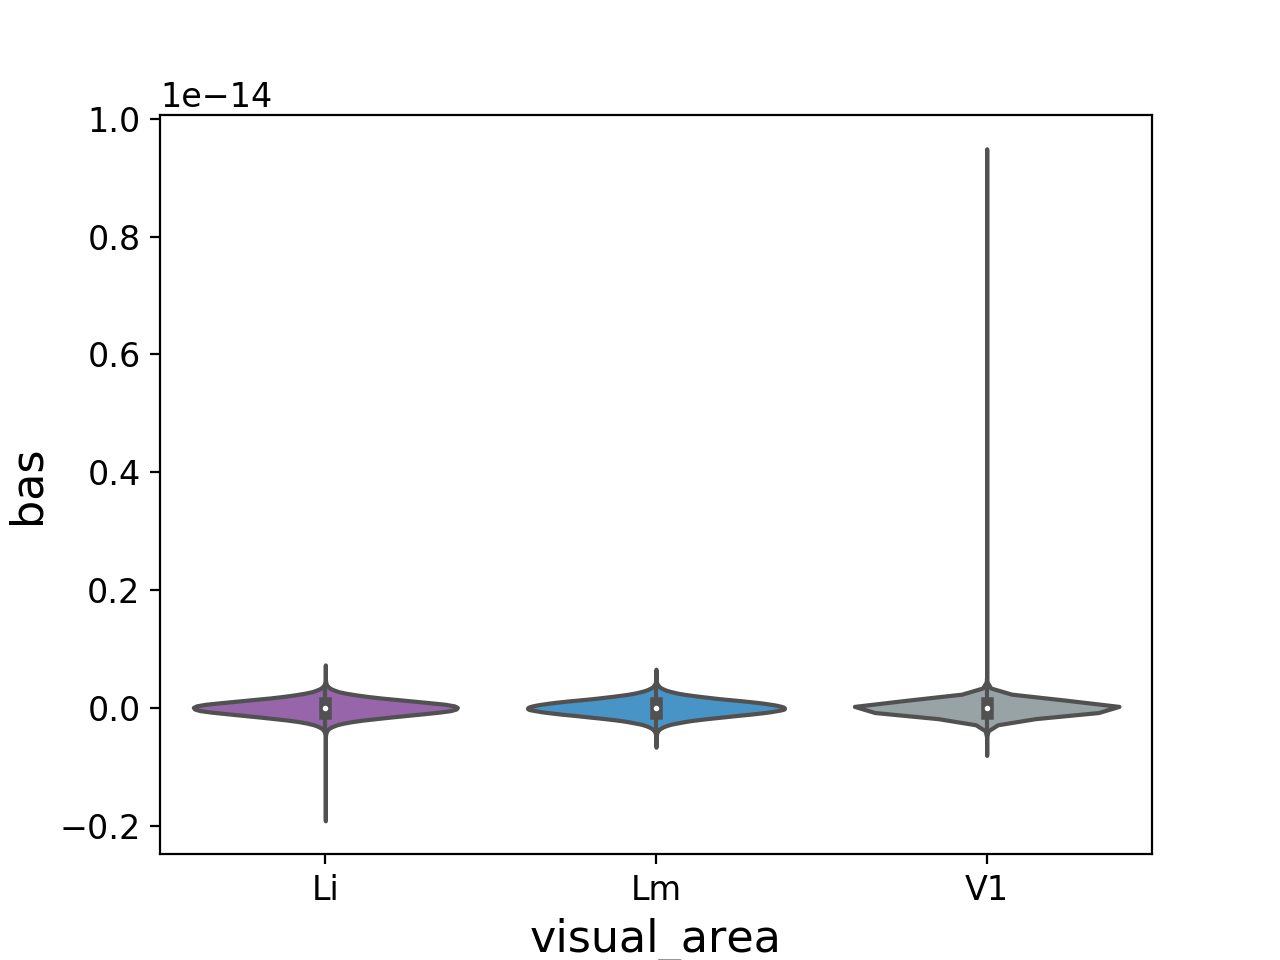

In [71]:
fig, ax = pl.subplots()
# for visual_area, g in bas.groupby(['visual_area']):
#     sns.distplot(g['bas'], ax=ax)
#sns.boxplot(x='visual_area', y='bas', data=bas, ax=ax, fliersize=5)
sns.violinplot(x='visual_area', y='bas', data=bas, ax=ax) #, fliersize=5)